In [82]:
from __future__ import print_function

In [77]:
%matplotlib notebook
import pandas as pd
import numpy as np
import csv
import os
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [78]:
def file_reader(file_path, num_rows=None, chunksize=None):
    if chunksize is None:
        return pd.read_csv(file_path, encoding='gbk', nrows=num_rows, chunksize=chunksize)
    else:
        chunks = pd.read_csv(file_path, encoding='gbk', nrows=num_rows, chunksize=chunksize)
        return pd.concat(chunks)

In [79]:
def get_absolute_file_path(folder_name, file_name):
    return os.path.join(os.path.dirname(os.getcwd()), folder_name, file_name)

In [7]:
# set up all file path
user_file_path = get_absolute_file_path('data', 'JData_User.csv')
product_file_path = get_absolute_file_path('data', 'JData_Product.csv')
comment_file_path = get_absolute_file_path('data', 'JData_Comment(修正版).csv')
action_02_file_path = get_absolute_file_path('data', 'JData_Action_201602.csv')
action_03_extra_file_path = get_absolute_file_path('data', 'JData_Action_201603_extra.csv')
action_03_file_path = get_absolute_file_path('data', 'JData_Action_201603.csv')
action_04_file_path = get_absolute_file_path('data', 'JData_Action_201604.csv')

In [12]:
# read files
user_file = file_reader(user_file_path)
product_file = file_reader(product_file_path, 10)
comment_file = file_reader(comment_file_path, 10)
action_02_file = file_reader(action_02_file_path, 10)
action_03_extra_file = file_reader(action_03_extra_file_path, 10)
action_03_file = file_reader(action_03_file_path, 10)
action_04_file = file_reader(action_04_file_path, 10)

## Basic Statistical Description

In [80]:
# user file
user_file.head()

,user_id,age,sex,user_lv_cd,user_reg_dt
0,54,-1,2,1,2016/1/26
1,79,36-45岁,2,2,2016/1/27
2,100,16-25岁,2,3,2016/1/27
3,266,15岁以下,2,2,2016/1/29
4,333,-1,2,4,2016/1/30


In [83]:
print('User File Length:', len(user_file))
print('Unique User ID:', len(pd.unique(user_file['user_id'])))

User File Length: 103616
Unique User ID: 103616


User file stores all unique user data, totally 103616

[u'-1' u'36-45\u5c81' u'16-25\u5c81' u'15\u5c81\u4ee5\u4e0b' u'26-35\u5c81'
 u'46-55\u5c81' u'56\u5c81\u4ee5\u4e0a']


In [32]:
product_file.head()

,sku_id,attr1,attr2,attr3,cate,brand
0,166731,1,-1,-1,8,545
1,146488,2,2,-1,8,812
2,70546,3,1,1,8,214
3,92487,2,2,-1,8,812
4,113065,2,2,-1,8,812


In [33]:
comment_file.head()

,dt,sku_id,comment_num,has_bad_comment,bad_comment_rate
0,2016-02-01,83714,4,1,0.0393
1,2016-02-01,125225,3,1,0.0833
2,2016-02-01,76379,4,1,0.0328
3,2016-02-01,150212,1,0,0.0000
4,2016-02-01,123004,2,0,0.0000


In [34]:
action_04_file.head()

,user_id,sku_id,time,model_id,type,cate,brand
0,100259,159398,2016-04-01 19:33:47,NaN,6,4,752
1,100259,159398,2016-04-01 19:33:55,NaN,6,4,752
2,100259,159398,2016-04-01 19:28:37,NaN,6,4,752
3,100259,159398,2016-04-01 19:33:18,NaN,6,4,752
4,56097,32453,2016-04-01 06:57:37,NaN,6,9,640


## Cluster product

In [84]:
product_file_path = get_absolute_file_path('data', 'JData_Product.csv')
product_file = file_reader(product_file_path, None)

In [85]:
product_file.hist(alpha=0.5)

<IPython.core.display.Javascript object>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1232a1dd8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x124b77390>]], dtype=object)

## Sample dataset

In [24]:
def generate_small_training_set(frac=0.1, random_state=100):
    user_file_path = get_absolute_file_path('data', 'JData_User.csv')
    user_file = file_reader(user_file_path, None)
    sampled_user = user_file.sample(frac=frac, random_state=random_state)['user_id']
    
    action_file_name_list = [
        'JData_Action_201602.csv', 
        'JData_Action_201603_extra.csv', 
        'JData_Action_201603.csv', 
        'JData_Action_201604.csv']
    
    filtered_action_file = list()
    for action_file_name in action_file_name_list:
        print('loading {}'.format(action_file_name))
        action_file_path = get_absolute_file_path('data', action_file_name)
        action_file = file_reader(action_file_path, None)
        filtered_action_file.append(action_file.loc[action_file['user_id'].isin(sampled_user)])
        
    return pd.concat(filtered_action_file, ignore_index=True)

In [60]:
sampled_training_set = generate_small_training_set(frac=0.10)

loading JData_Action_201602.csv
loading JData_Action_201603_extra.csv
loading JData_Action_201603.csv
loading JData_Action_201604.csv


## Number of products sold by time

<IPython.core.display.Javascript object>


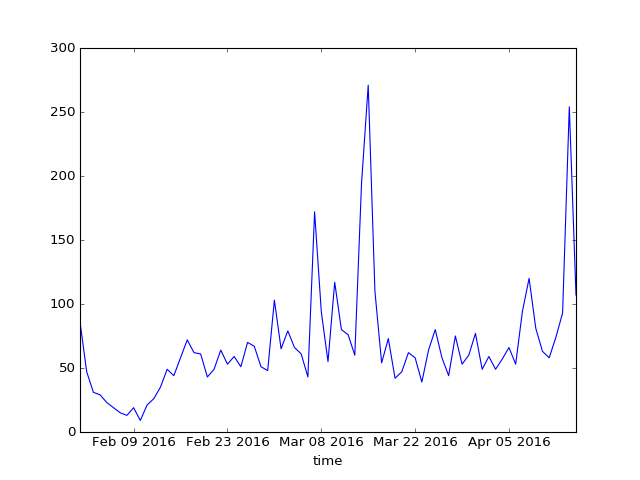

In [72]:
sold_product = sampled_training_set.loc[sampled_training_set['type']==4]
sales_by_time = sold_product.groupby(pd.to_datetime(sold_product['time']).dt.date).count()
sales_by_time.time.plot()


## Baseline
First start with a simple rule_based model use a user's most recent actions frequency to predict its next purchase action 

In [83]:
def generate_training_data(action_file):
    grouped_action = pd.DataFrame(action_file.groupby(['user_id', 'sku_id', 'type']).size().rename('counts'))
    grouped_action = grouped_action.reset_index()
    return grouped_action

In [77]:
action_04 = file_reader(action_04_file_path, None, 1000)

In [85]:
training_samples = generate_training_data(action_04)
training_samples.head()

,user_id,sku_id,type,counts
0,1,124997,1,10
1,1,124997,6,11
2,2,4919,1,2
3,2,4919,6,3
4,2,7746,1,6


In [ ]:
def rule(candidates):
    

def rule_based_prediction(training_samples):
    pred = dict()
    for user_id in training_samples:
        sku_id = rule(training_samples[user_id])
        pred[user_id] = sku_id
        
    return pred

## Machine Learning

In [ ]:
class model(object):
    def __init__(self):
        
    def train(self):
        
    def test(self):
        
      